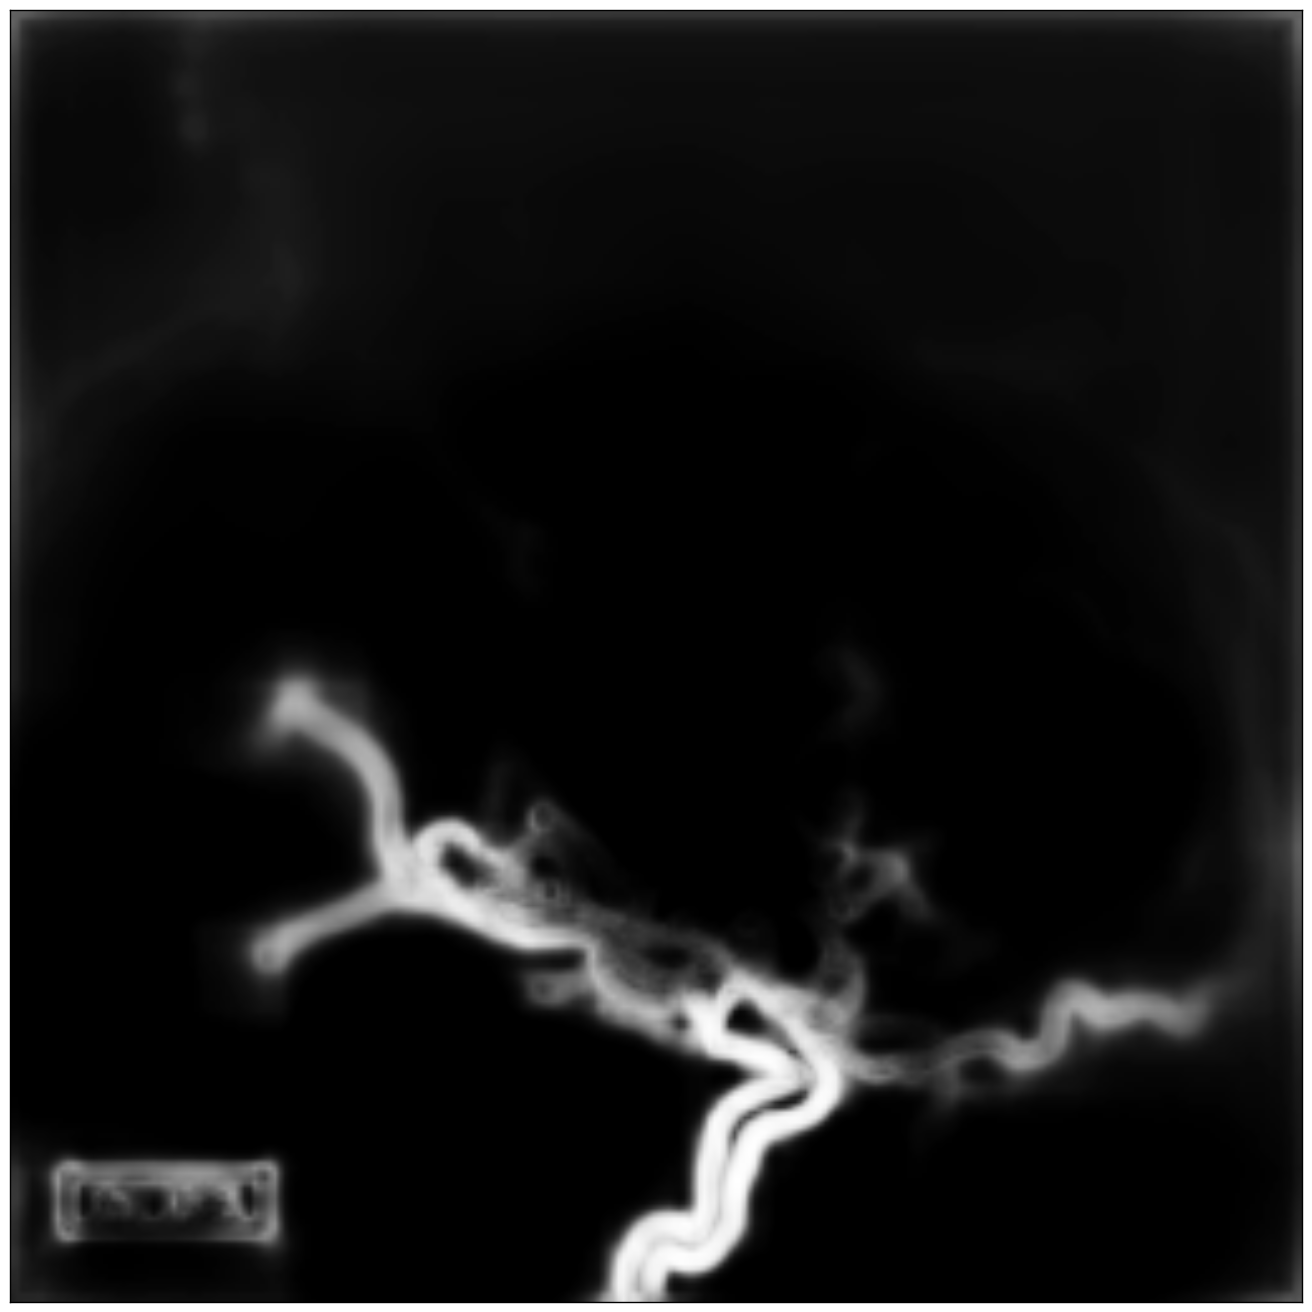

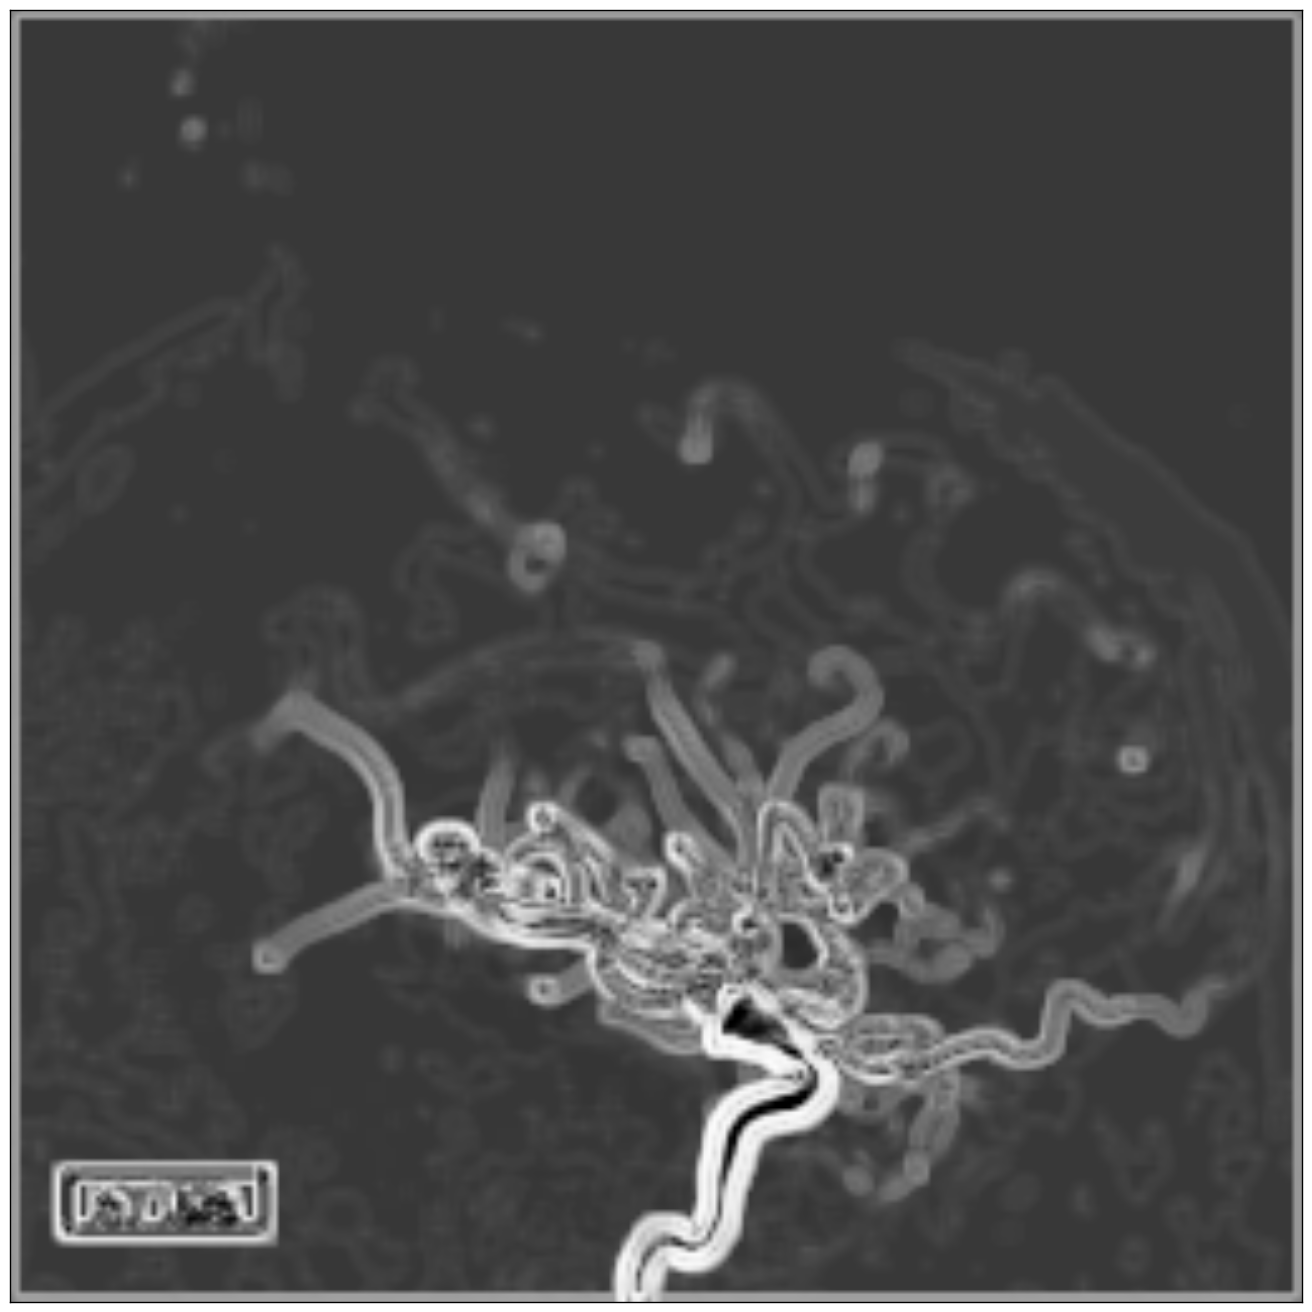

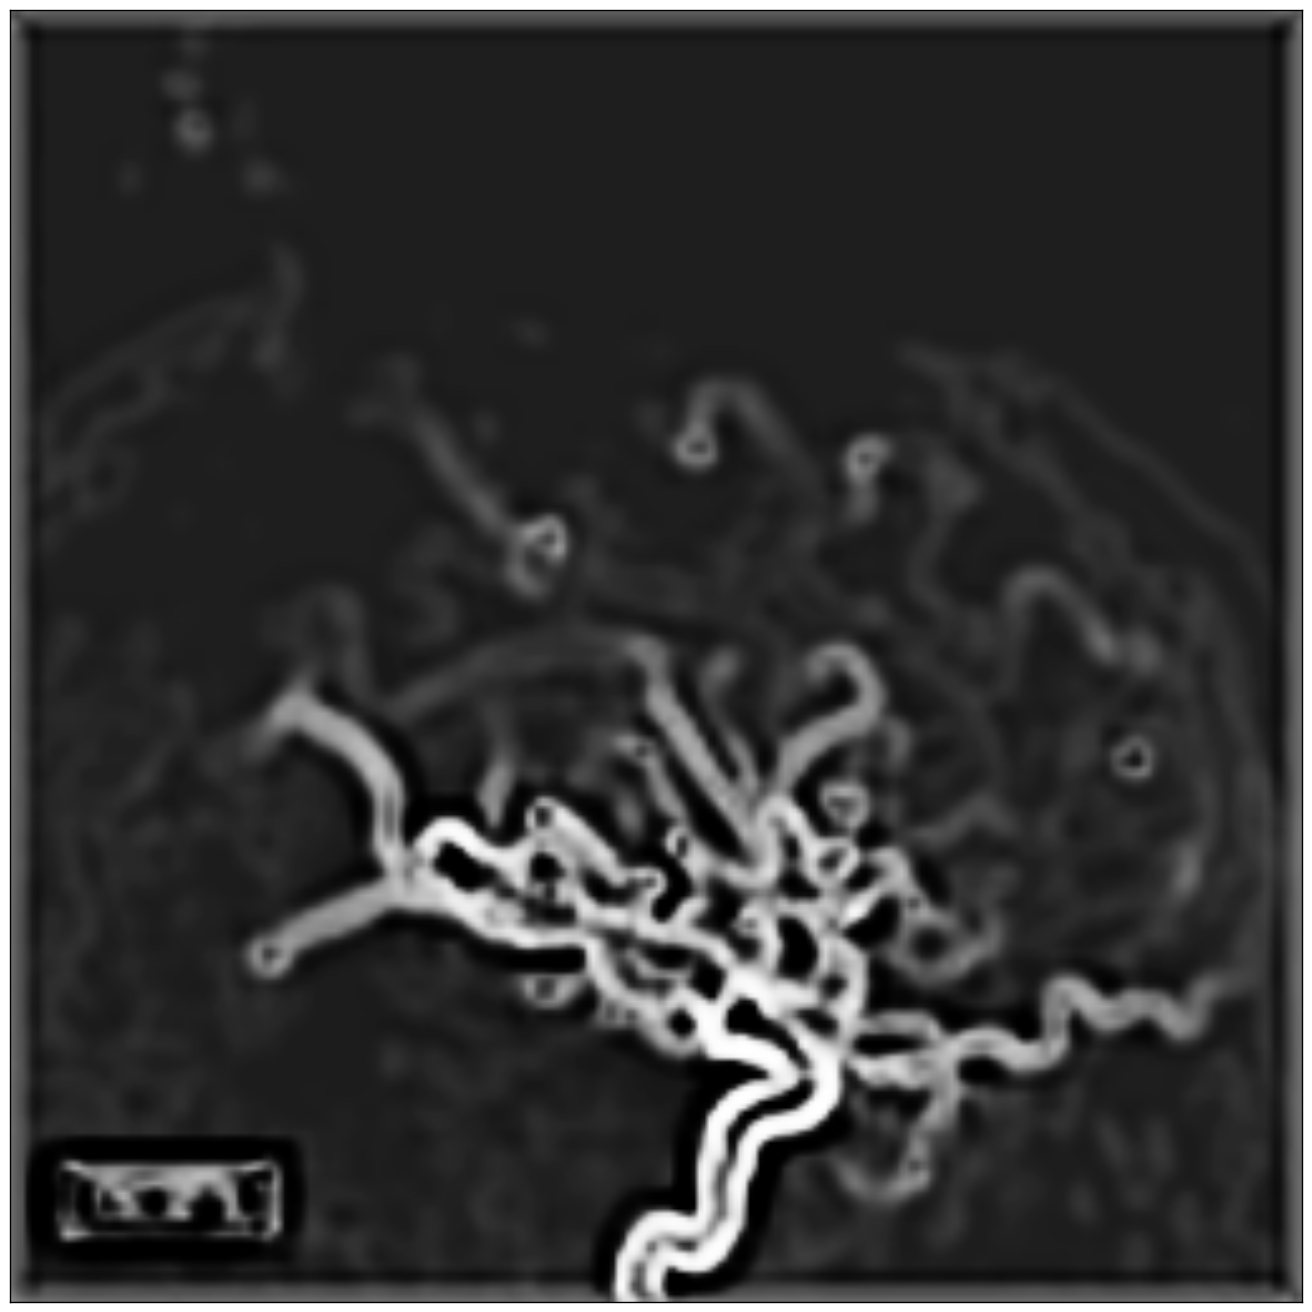

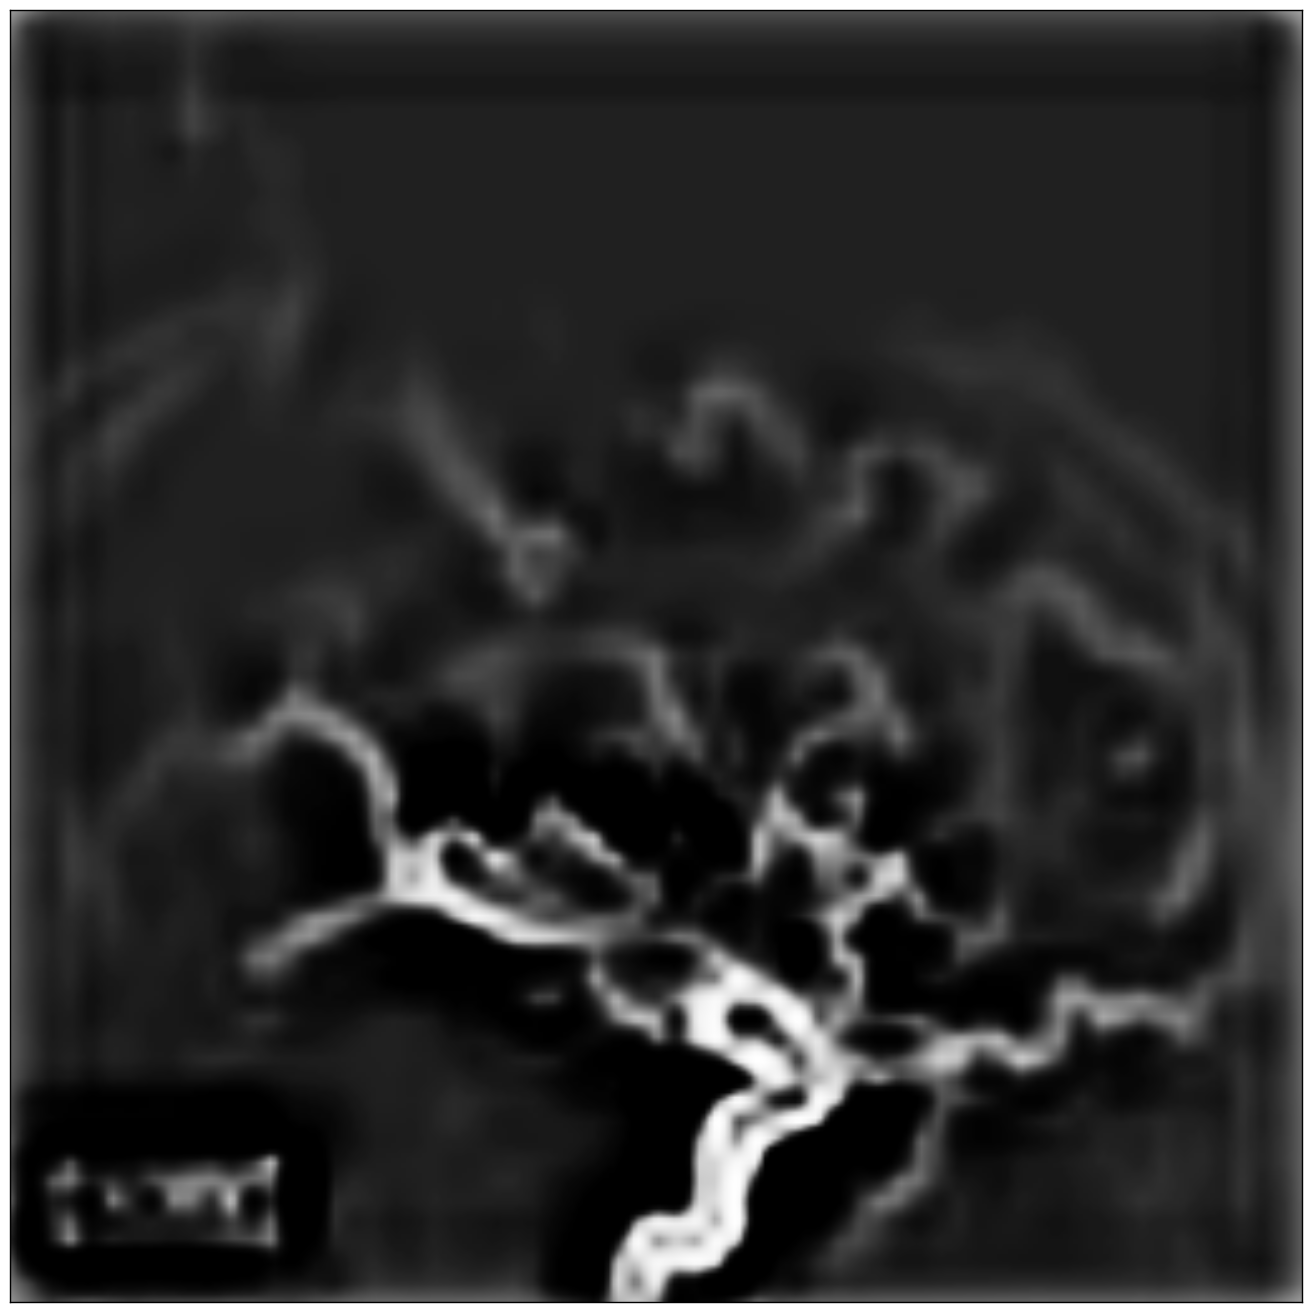

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
import scipy.misc
import PIL
from PIL import Image
import scipy.io
import os
import cv2


# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/hed/
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
    
#Visualization
def plot_single_scale(scale_lst, size, dst):
    pylab.rcParams['figure.figsize'] = size, size
    
    for i in range(0, len(scale_lst)):
        s = plt.figure()
        plt.imshow(1-scale_lst[i], cmap = cm.binary)
        plt.xticks([])
        plt.yticks([])
        s.savefig(str(i+1) + dst, bbox_inches='tight', pad_inches=0)
        s.tight_layout()    

data_root = '/Users/shitij/Google Drive/CS188/Vessel Annotation/data/'
imname = '61bl.png'
im = cv2.imread(data_root+imname, 0)

#equalize Histogram (equalize on 1024, denoise and dont resize - for best result with equalization)
# in_ = cv2.equalizeHist(im)
# in_ = cv2.fastNlMeansDenoising(in_,None,10,7,21)

#resize Image (Denoise and resize for good result)
in_ = cv2.fastNlMeansDenoising(im,None,10,7,21)
in_ = cv2.resize(in_, (0, 0), fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)

in_ = np.array(in_, dtype=np.float32)

#gray to RGB
w, h = in_.shape
ret = np.empty((w, h, 3), dtype=np.float32)
ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] =  in_
in_ = ret

in_ = in_[:,:,::-1]
in_ -= np.array((240.00698793,240.66876762,240.67891434))
in_ = in_.transpose((2,0,1))

#remove the following two lines if testing with cpu
#caffe.set_mode_gpu()
#caffe.set_device(0)

# load net
model_root = './'
net = caffe.Net(model_root+'deploy.prototxt', model_root+'hed_pretrained_bsds.caffemodel', caffe.TEST)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

# Scale size = 1024*1024: 1024px == 13.22 inches
scale_lst = [fuse]
plot_single_scale(scale_lst, 13.22, '_fuse_' + imname)
scale_lst = [out1, out2, out3, out4, out5]
plot_single_scale(scale_lst, 13.22, '_out_' + imname)